In [1]:
import numpy as np

In [97]:
class Dense_Layer:
    def __init__(self,ninputs,nneurons):
        # Initialising weights and biases
        self.weights = 0.01 * np.random.randn(ninputs,nneurons)
        self.biases = np.zeros((1,nneurons))
        
    # Forward Propagation    
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    # Backpropagation
    def backward(self,dvalues):
        self.dinputs = np.dot(dvalues,self.weights.T)
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)

In [98]:
class Activation_Relu:
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        

In [99]:
class Activation_Softmax:
    def forward(self,inputs,y_true):
        expvals = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True) )
        self.output = expvals/np.sum(expvals,axis=1,keepdims=True)

In [110]:
class CrossEntropyLoss:
    def calculate(self,y_pred,y_true):
        # Turning one hot encoded values into sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        # Clipping to prevent log with 0
        ypred = np.clip(y_pred,1e-7,1-1e-7)
        
        return np.mean(-np.log(y_pred[range(len(y_pred)),y_true]))
    


In [111]:
class Activation_softmax_cross_entropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.lossfunc = CrossEntropyLoss()
    
    def forward(self,inputs,y_true):
        self.activation.forward(inputs,y_true)
        self.output = self.activation.output
        return self.lossfunc.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(y_true)
        
        # Turning one hot encoded arrays to sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        
        self.dinputs/=samples

In [175]:
class SGD_Optimizer:
    def __init__(self,lr=1,decay_rate=0.1,momentum=0.):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if self.momentum:
            # if we don't have momentum arrays create them
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = \
                self.momentum * layer.weight_momentums - self.currentlr * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = \
                self.momentum * layer.bias_momentums - self.currentlr * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = -self.currentlr * layer.dweights
            bias_updates = -self.currentlr * layer.dbiases
                
        
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update(self):
        self.iterations += 1

In [163]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [126]:
X,y = make_circles(n_samples=1000,noise=.05)

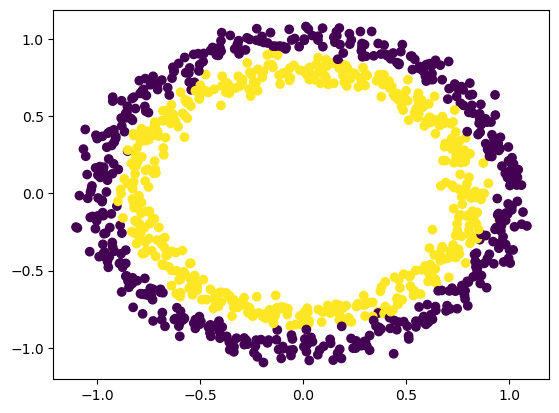

In [127]:
plt.scatter(X[:,0],X[:,1],c=y)

In [128]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [181]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,2)
actloss = Activation_softmax_cross_entropy()
optimizer = SGD_Optimizer(1,decay_rate=1e-3,momentum=0.5)

for epoch in range(1001):
    layer1.forward(X_train)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y_train)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y_train)
    if epoch % 100 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y_train)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

Epoch :  0  Accuracy :  0.5014925373134328  Loss :  0.6931483467687305
Epoch :  100  Accuracy :  0.9104477611940298  Loss :  0.5411476815044776
Epoch :  200  Accuracy :  0.9776119402985075  Loss :  0.17559232263597738
Epoch :  300  Accuracy :  0.9791044776119403  Loss :  0.08803736157997546
Epoch :  400  Accuracy :  0.9850746268656716  Loss :  0.06610840249751694
Epoch :  500  Accuracy :  0.9835820895522388  Loss :  0.056645115587506095
Epoch :  600  Accuracy :  0.9850746268656716  Loss :  0.051160726614188023
Epoch :  700  Accuracy :  0.9835820895522388  Loss :  0.047348830052674824
Epoch :  800  Accuracy :  0.9835820895522388  Loss :  0.04486711445357384
Epoch :  900  Accuracy :  0.9835820895522388  Loss :  0.043076740552555316
Epoch :  1000  Accuracy :  0.9835820895522388  Loss :  0.04163375231944795


In [182]:
import nnfs
from nnfs.datasets import spiral_data

In [183]:
np.random.seed(0)

In [184]:
X,y = spiral_data(samples=100,classes=3)

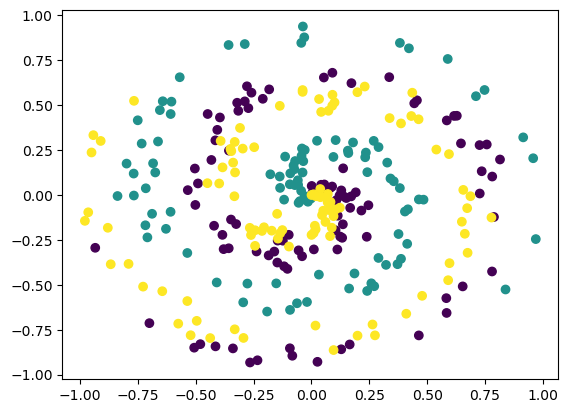

In [185]:
plt.scatter(X[:,0],X[:,1],c=y)

In [190]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = SGD_Optimizer(1,decay_rate=0.001,momentum=0.9)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.30666666666666664  Loss :  1.0986063738900536
Epoch :  1000  Accuracy :  0.8333333333333334  Loss :  0.39554627046265417
Epoch :  2000  Accuracy :  0.8566666666666667  Loss :  0.34442093939895435
Epoch :  3000  Accuracy :  0.88  Loss :  0.2931876401172989
Epoch :  4000  Accuracy :  0.8966666666666666  Loss :  0.24535637397744695
Epoch :  5000  Accuracy :  0.9133333333333333  Loss :  0.22840798773019966
Epoch :  6000  Accuracy :  0.9233333333333333  Loss :  0.2199474892804392
Epoch :  7000  Accuracy :  0.93  Loss :  0.21371925759514995
Epoch :  8000  Accuracy :  0.94  Loss :  0.20714743758335216
Epoch :  9000  Accuracy :  0.9433333333333334  Loss :  0.20286416809139043
Epoch :  10000  Accuracy :  0.9433333333333334  Loss :  0.19950705668642343
